# IMPORT LIBRARIES

In [1]:
library(caTools,quietly=TRUE)
library(dplyr,quietly=TRUE) 
library(stringr,quietly=TRUE) 
library(caret,quietly=TRUE) 
library(caTools,quietly=TRUE) 
library(ggplot2,quietly=TRUE) 
library(corrplot,quietly=TRUE)
library(randomcoloR,quietly=TRUE)
library(xgboost,quietly=TRUE)
library(gbm, quietly=TRUE)
library(randomForest, quietly=TRUE)
library(LogicReg,quietly=TRUE)
library(class,quietly=TRUE)
library(e1071,quietly=TRUE)
options(repr.plot.width=30, repr.plot.height=24)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


corrplot 0.92 loaded


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


Loaded gbm 2.1.8.1

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'survival'


The following object is masked from 'package:caret':

    cluster




# LOAD DATA

In [2]:
data <- read.csv('./Activity 2.csv')
data<-na.omit(data)

In [3]:
colnames(data)   #unique data fields

[1] "Time"   "V1"     "V2"     "V3"     "V4"     "V5"     "V6"     "V7"    
 [9] "V8"     "V9"     "V10"    "V11"    "V12"    "V13"    "V14"    "V15"   
[17] "V16"    "V17"    "V18"    "V19"    "V20"    "V21"    "V22"    "V23"   
[25] "V24"    "V25"    "V26"    "V27"    "V28"    "Amount" "Class"

# I. EXPLORATORY DATA ANALYSIS (EDA)

Since data fields (exclude Time, Amount and Class) have been anonymised because of privacy policies, then we have no reason to find  descriptive statistics for each of the variables.

## Imbalance of Class

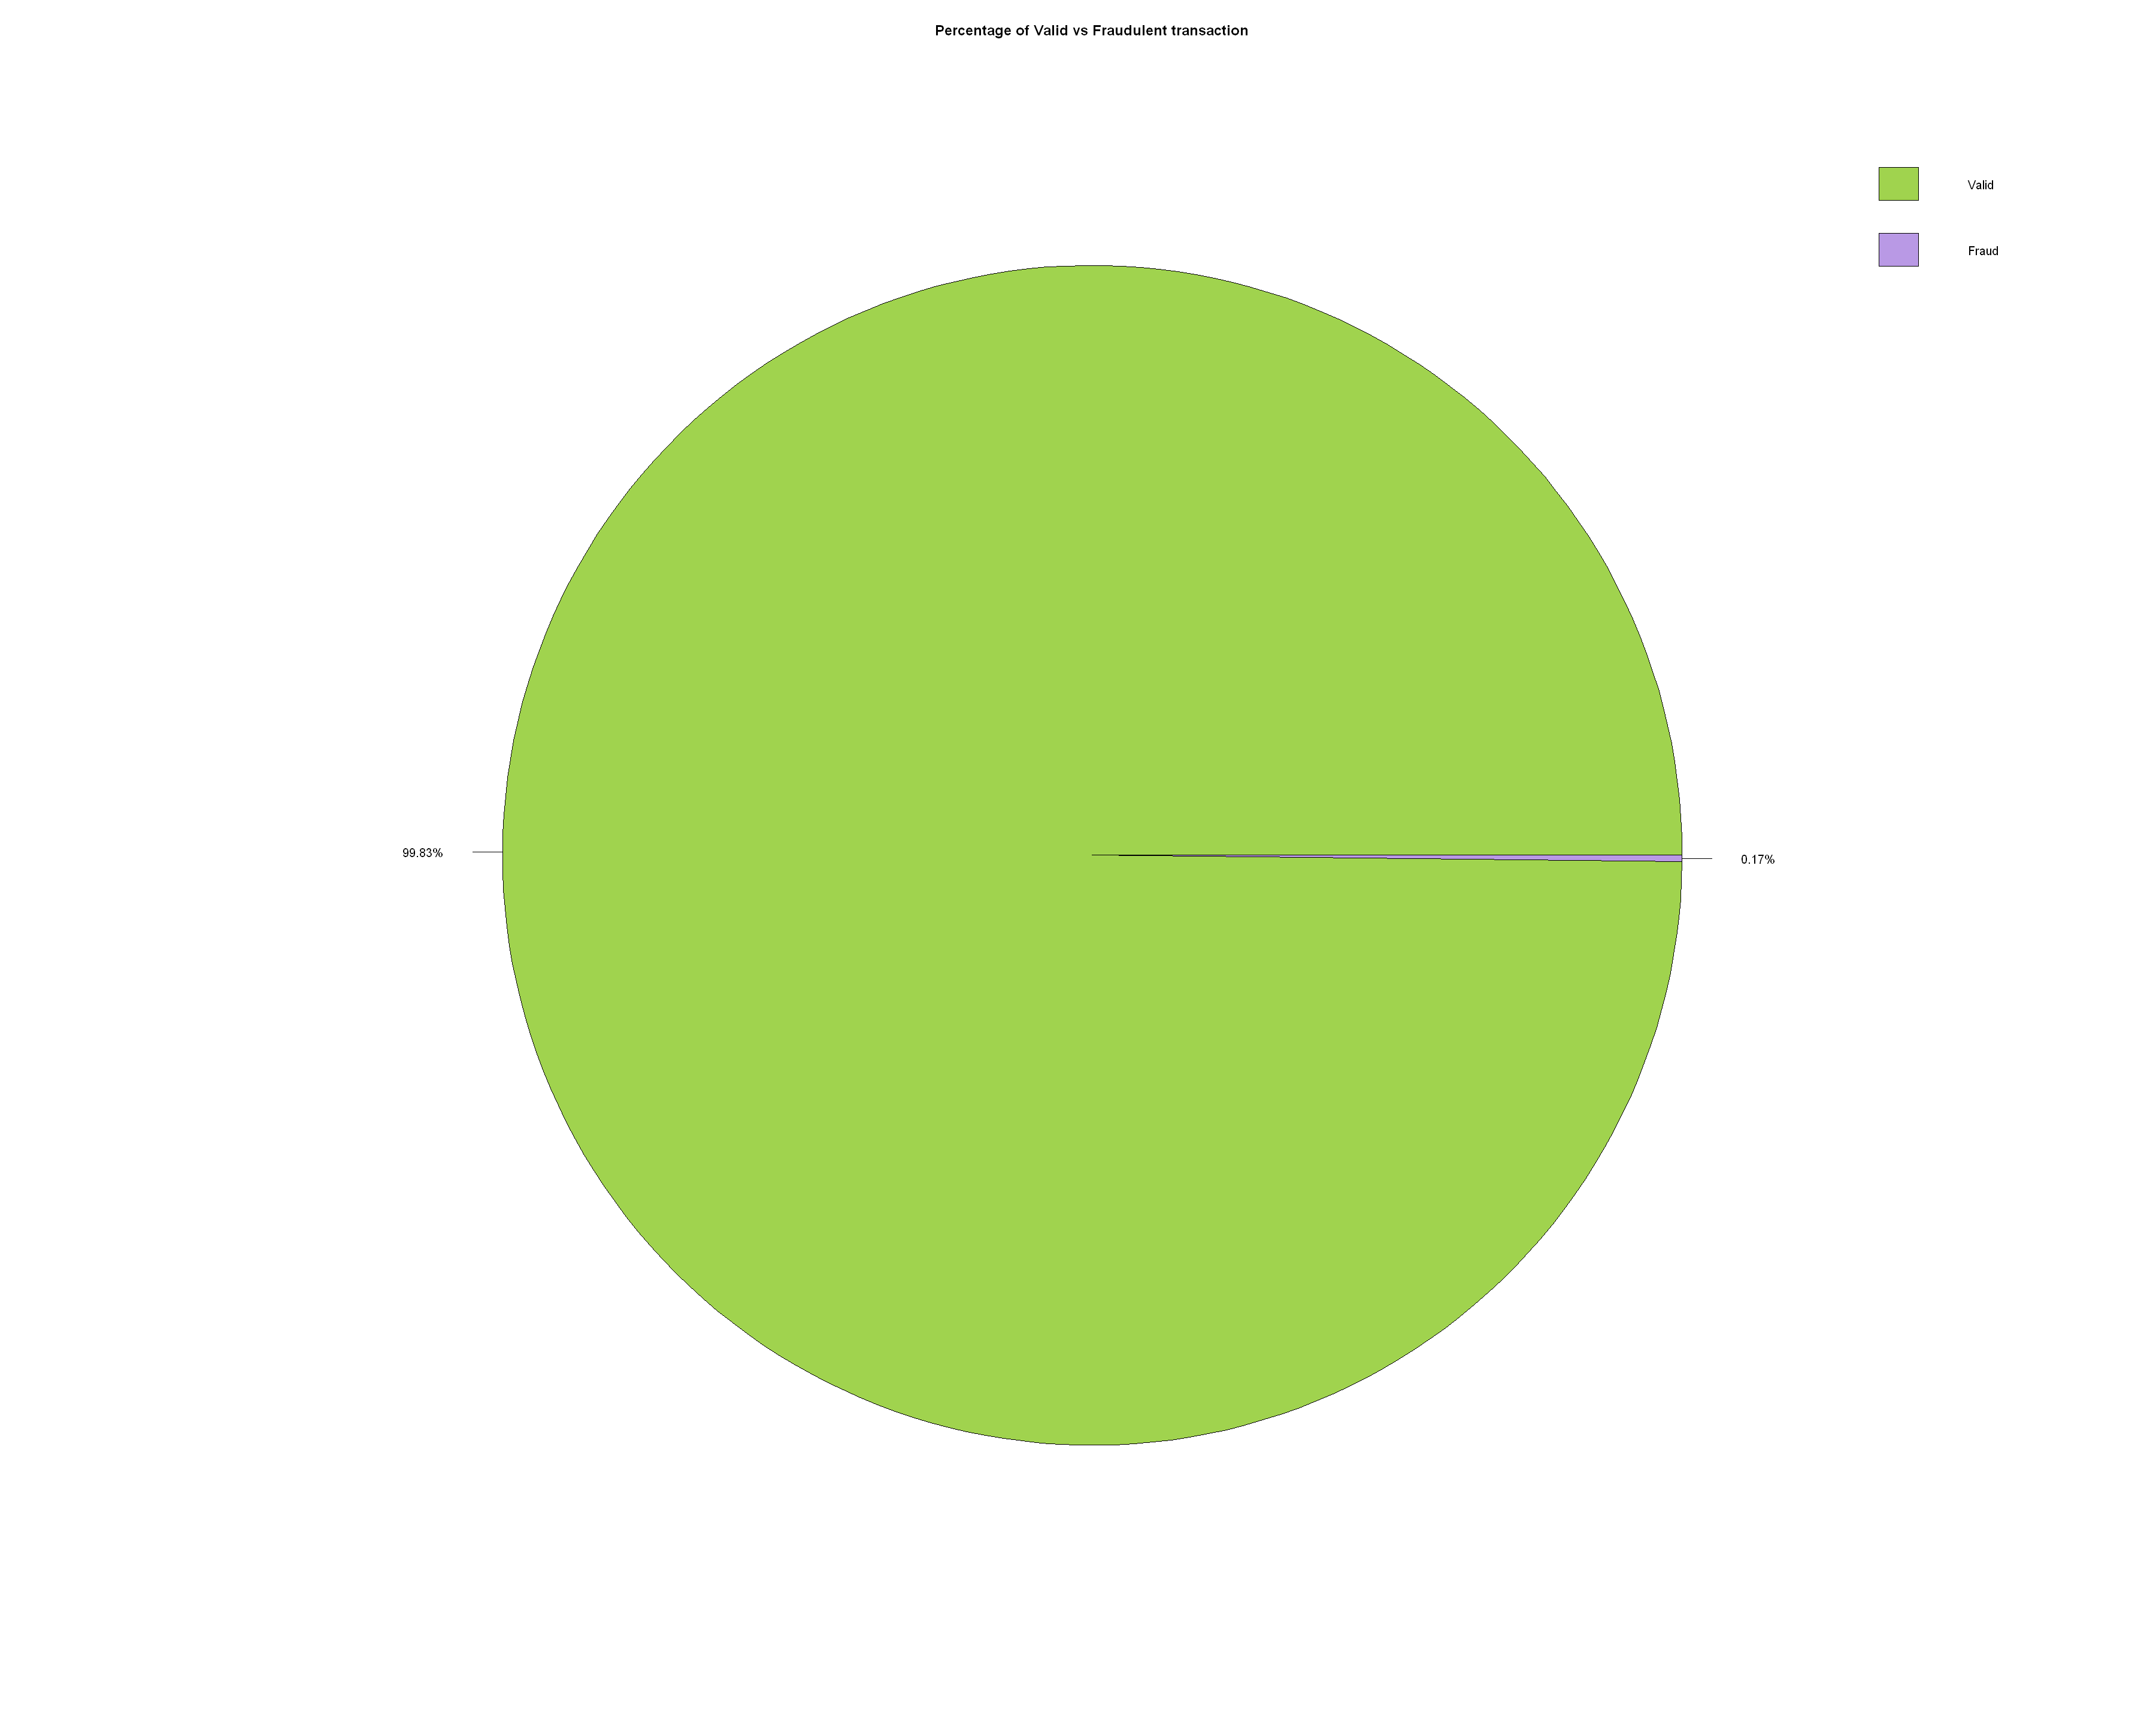

In [4]:
class = table(data$Class)
colors =  randomColor(2)
lb = paste0(round(prop.table(class)*100,2),"%")
pie(class,labels = lb, col =  colors,main="Percentage of Valid vs Fraudulent transaction")
legend(x=1,y=1,legend=c("Valid","Fraud"),fill=colors, bty = "n")

The data set is very unbalanced where 99.8% of cases are transactions without fraud. A simple metric such as accuracy is not appropriate here, as even a classification that flags all transactions as non-fraudulent has an accuracy of 99%. The alternative measure of model performance here is the <b>Confusion Matrix</b> and <b>AUC(Area Under the ROC Curve)</b>.

## Distribution of Time by Class

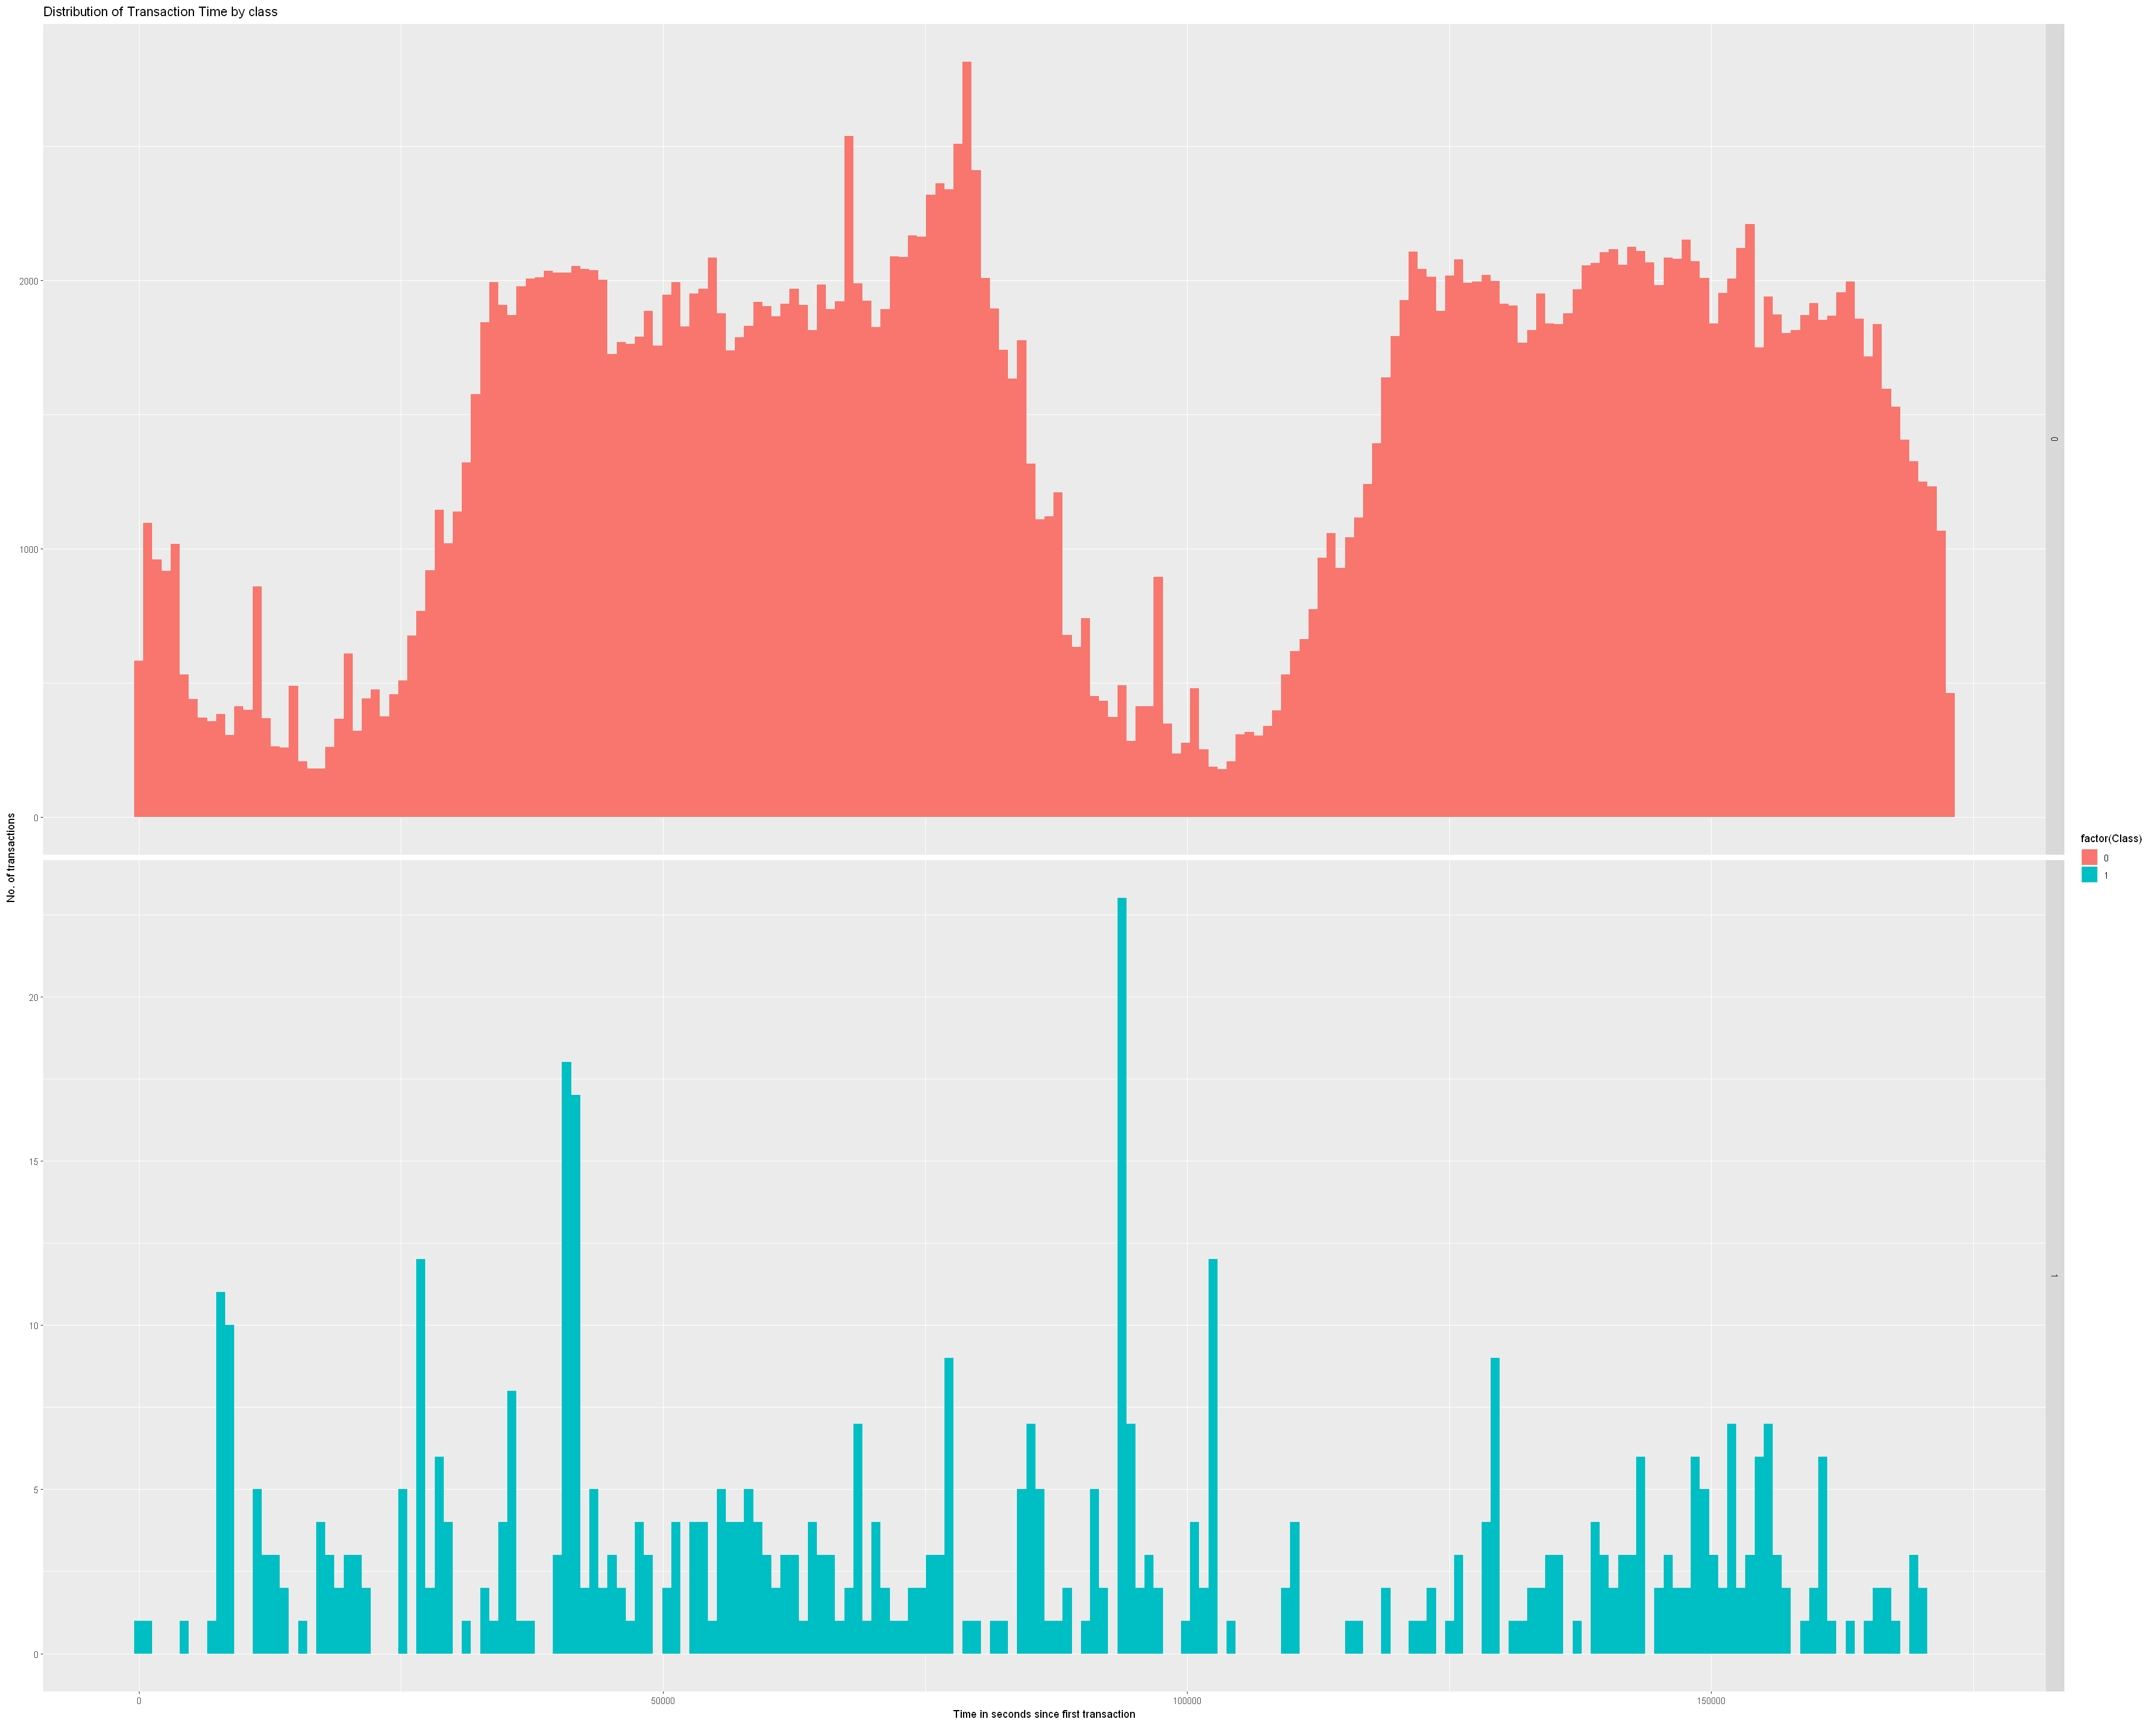

In [5]:
data %>%
  ggplot(aes(x = Time, fill = factor(Class))) + geom_histogram(bins = 200)+
  labs(x = 'Time in seconds since first transaction', y = 'No. of transactions') +
  ggtitle('Distribution of Transaction Time by class') +
  facet_grid(Class ~ ., scales = 'free_y')

## Distribution of Amount by Class

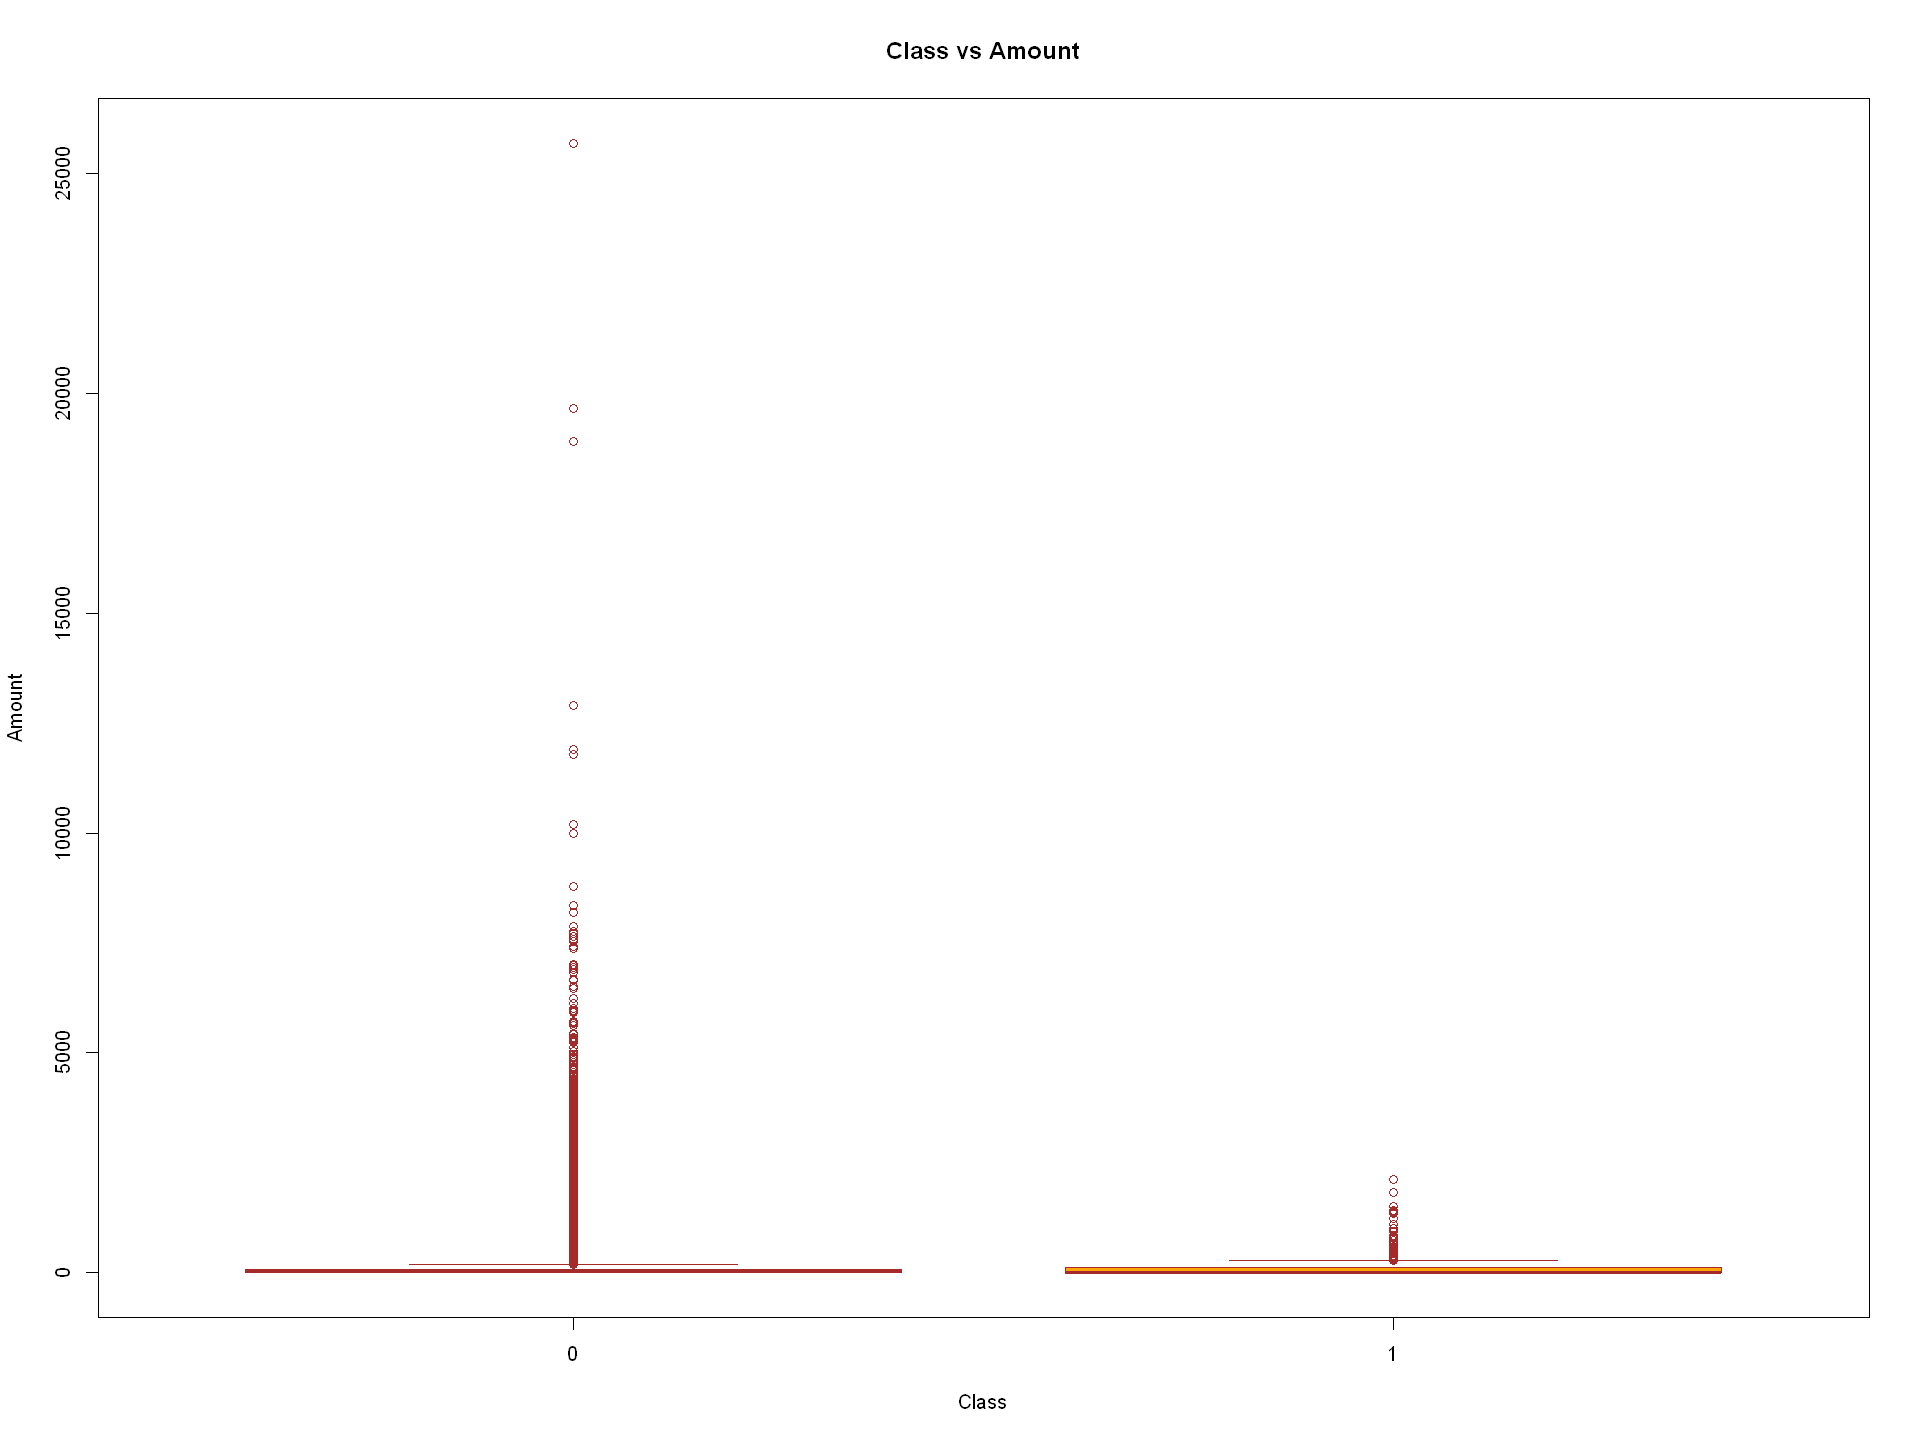

In [6]:
par(mfrow=c(1, 1))
options(repr.plot.width=16, repr.plot.height=12)
boxplot(Amount~Class,data=data,main="Class vs Amount", xlab="Class",ylab="Amount",col="orange",border="brown")

## DATA MANIPULATION

Based on the data description, we infer that the "Time" feature has little to no significance in correctly classifying a fraud transaction and, as a result, exclude this column from further analysis.

In [7]:
data$Time<-NULL
data = data %>% distinct()

## CORRPLOT

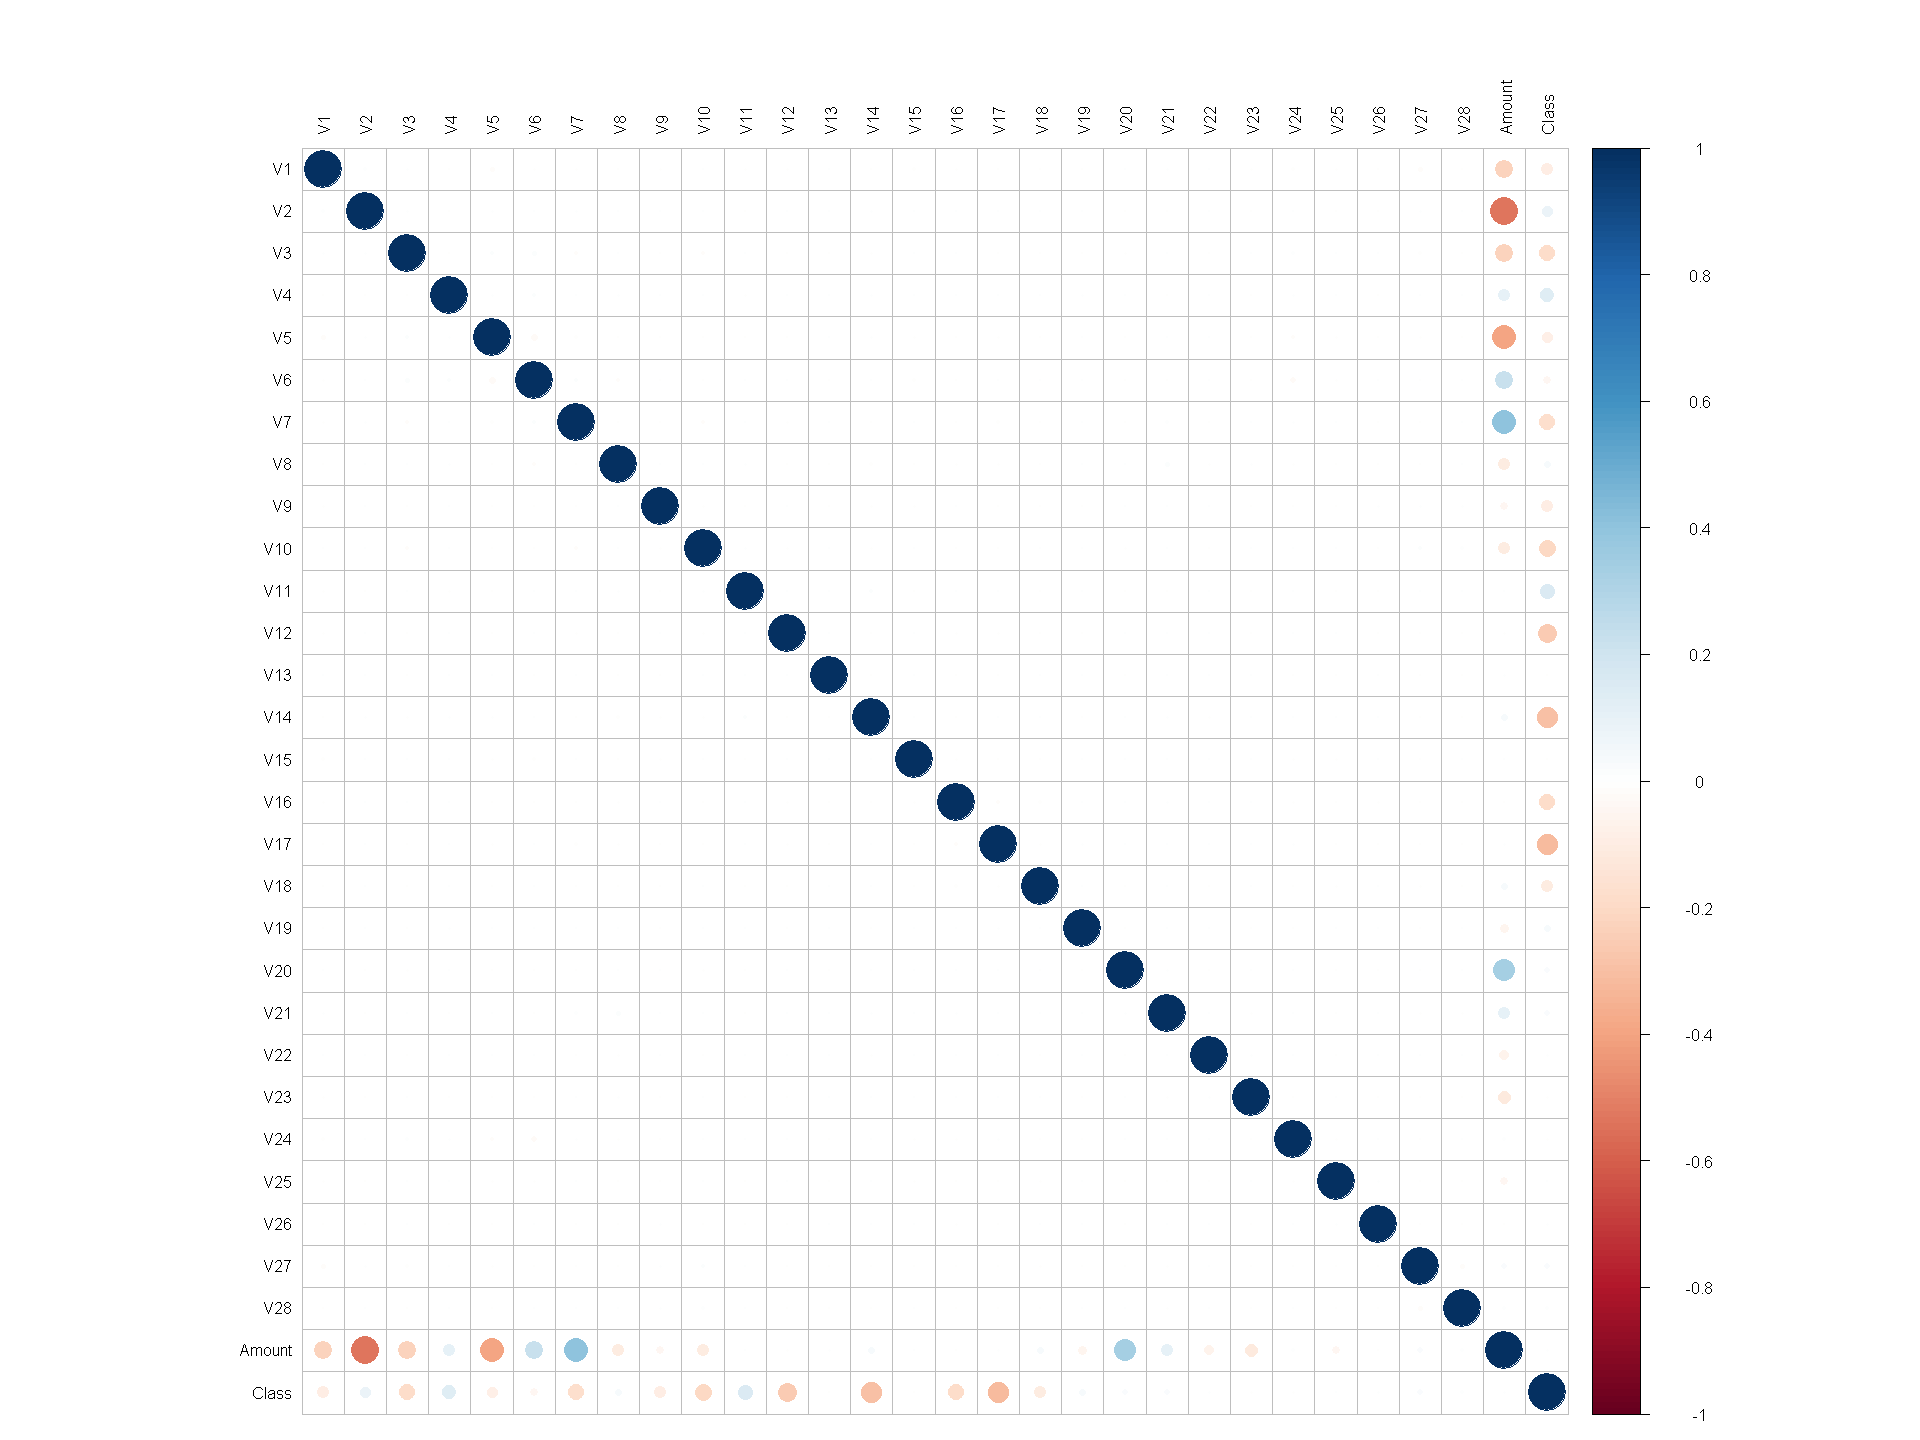

In [8]:
correlations <- cor(data,method="pearson")
corrplot(correlations, number.cex = .9, method = "circle", type = "full", tl.cex=0.8,tl.col = "black")

\- We see that most of the data features are uncorrelated. This is because many characteristics undergo Principal Component Analysis (PCA) algorithms before being published. Features V1 to V28 can be principal components extracted from the actual feature distribution by PCA.<br>- The top 3 independent variables {V12, V14, V17} may partly contains important information about whether a giving credit card transaction is fraudulent or not.

In [9]:
data$Class <- as.factor(data$Class)

# II. FITTING VARIOUS MODELS

## SPLIT DATA INTO TRAIN SET AND TEST SET

In [10]:
#make this split test reproducible
set.seed(42)
#use 70% of dataset as training set and 30% as test set
split <- sample.split(data,SplitRatio = 0.70)
train_df <- subset(data,split==TRUE)
test_df <- subset(data,split==FALSE)

In [11]:
library(pROC)
library(ROCR)
library(ROSE)
library(doParallel) #for parallel computing

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loaded ROSE 0.0-4


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel


Attaching package: 'kernlab'


The following object is masked from 'package:ggplot2':

    alpha




## Upsampling

This method works with the minority class. It reproduces the observations of the minority class to balance the data. It is also known as oversampling. Similar to downsampling, this technique can also be divided into two types: random oversampling and informational oversampling.

The random oversampling balances the data with the random oversampling of the minority class. Informative oversampling uses a pre-specified criterion and synthetically generates observations of minority classes.

An advantage of this method is that no information is lost. The downside of using this method is that because oversampling simply adds replicate observations to the original data set, it ends up adding more observations of different types, leading to overfitting.

In [12]:
set.seed(9999)
up_train <- upSample(x = train_df[, -ncol(train_df)],
                         y = train_df$Class)

## 1. LOGISTIC REGRESSION CLASSIFIER (GENERALIZED LINEAR MODEL)

In [13]:
cl <- makePSOCKcluster(12)
registerDoParallel(cl)
model_lr <- glm(Class~.,data=up_train, family='binomial')
stopCluster(cl)
registerDoSEQ()

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


### Confusion Matrix / AUC 

In [15]:
predict_lr = predict(model_lr, newdata = test_df,type = "response")
table(ifelse(predict_lr>0.5,'1','0'),test_df$Class)

   
        0     1
  0 80349     4
  1  2221   125

Area under the curve (AUC): 0.990

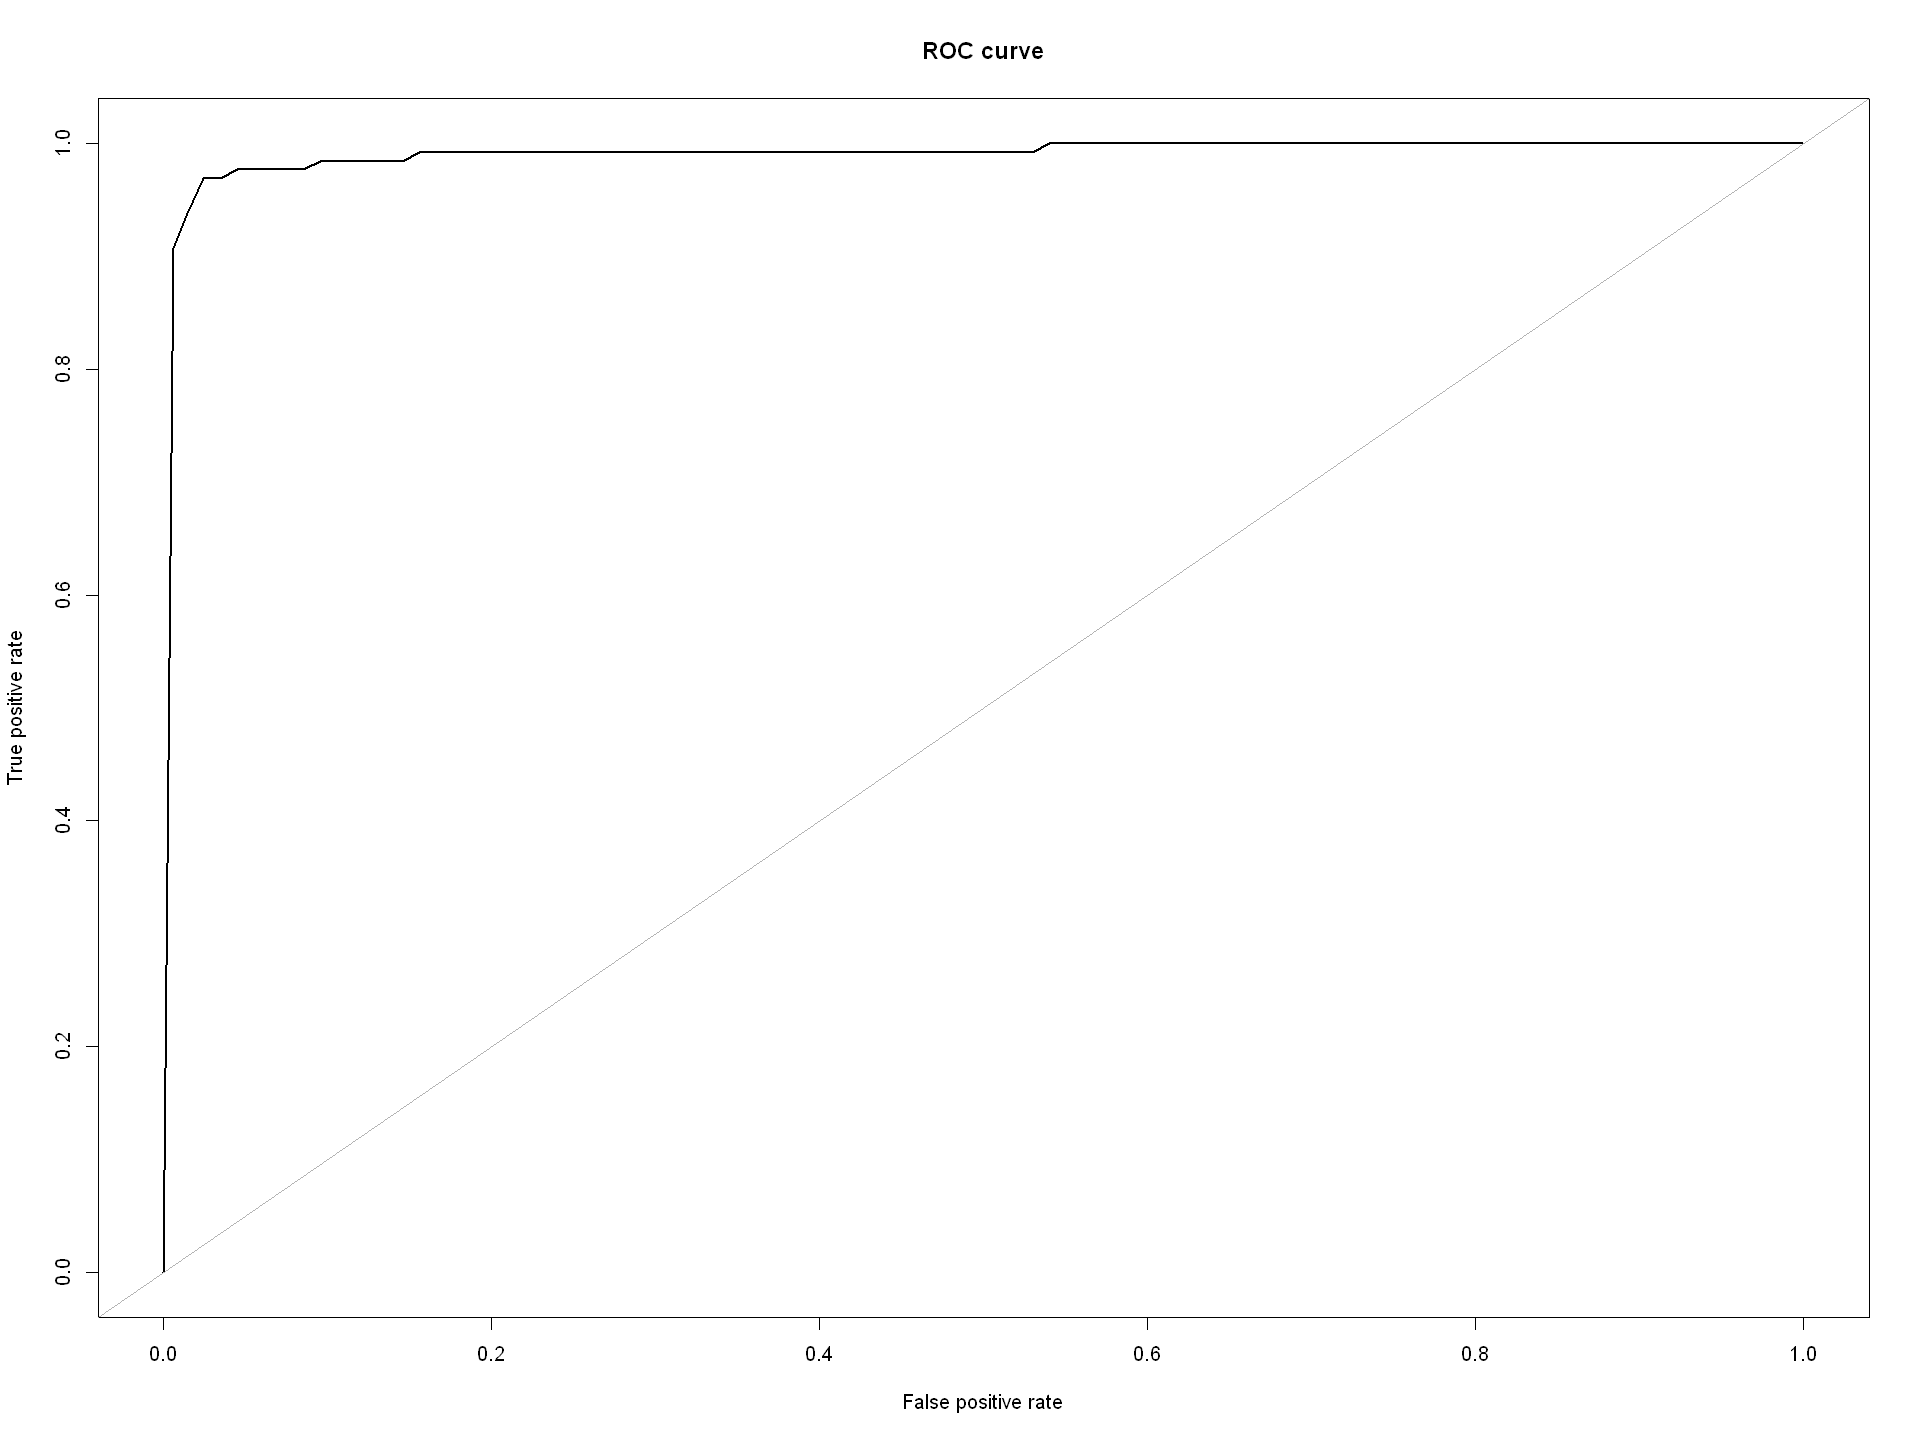

In [16]:
roc.curve(test_df$Class, predict_lr, plotit =TRUE)

## 2. EXTREME GRADIENT BOOSTING CLASSIFIER

In [15]:
xgboost_train = xgb.DMatrix(data=data.matrix(up_train[,-30]), label=up_train$Class)
xgboost_test = xgb.DMatrix(data=data.matrix(test_df[,-30]), label=test_df$Class)

In [16]:
cl <- makeCluster(12)
registerDoParallel(cl)
model_xgb <- xgboost(data = xgboost_train, 
                 max.depth=3,
                verbose = FALSE,
                 nrounds=50)  
predict_xgb = predict(model_xgb, newdata=xgboost_test)
stopCluster(cl)
registerDoSEQ()

### AUC

Area under the curve (AUC): 0.985

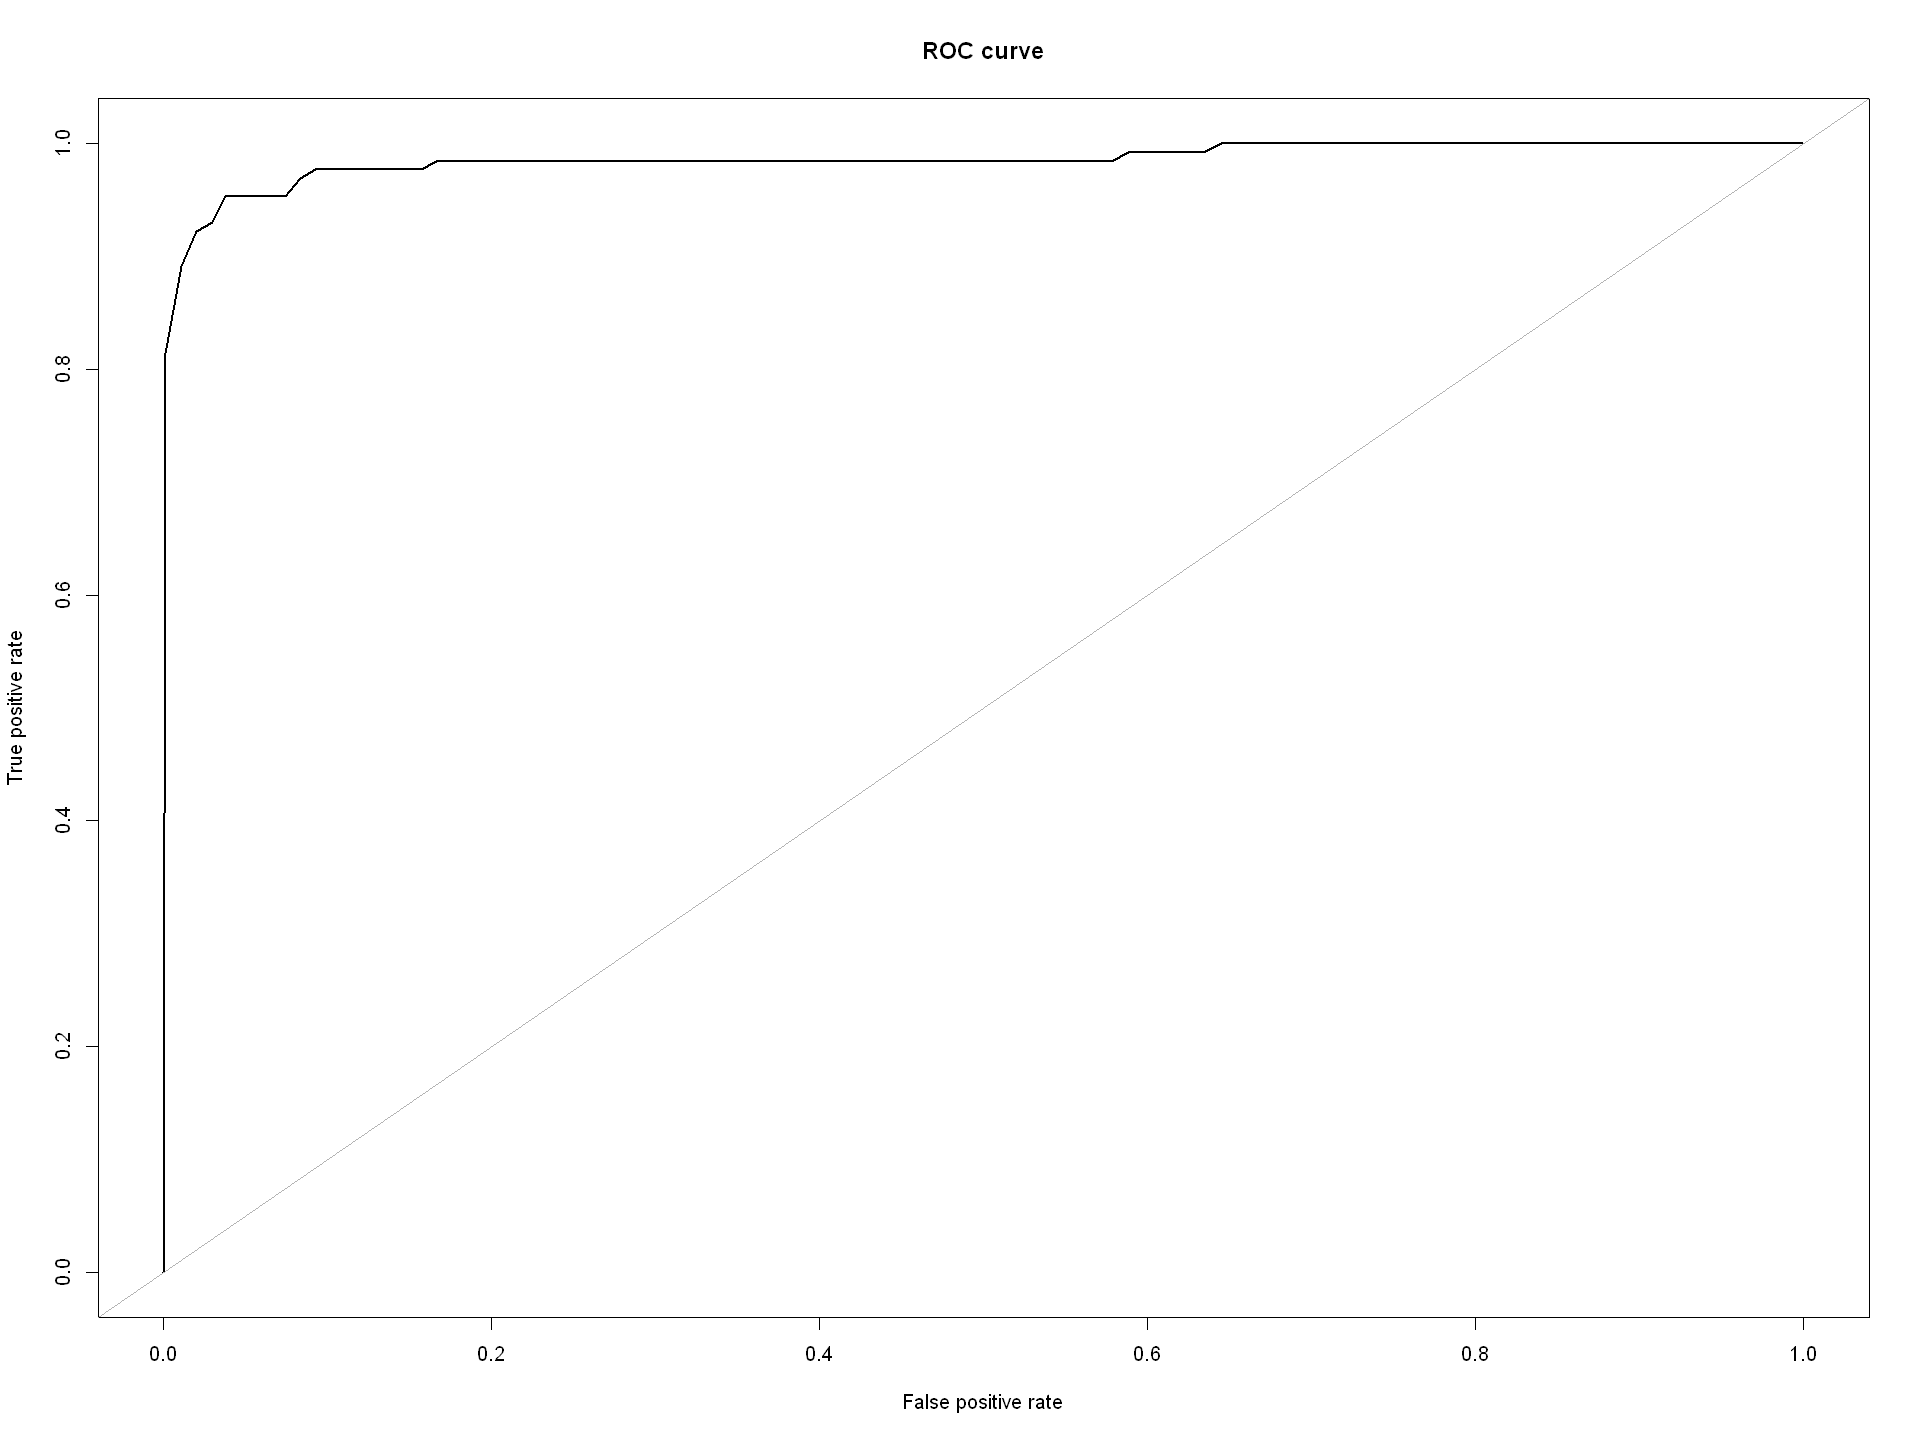

In [20]:
roc.curve(test_df$Class, predict_xgb, plotit =TRUE)

## 3. SUPPORT VECTOR MACHINE

In [9]:
#Remove comments to make the code available
# cl <- makePSOCKcluster(12)
# registerDoParallel(cl)
# model_svm =  svm(Class ~ ., 
#                data = up_train, 
#                type = "C-classification", 
#                kernel = "linear", 
#                scale = FALSE)
# stopCluster(cl)
# registerDoSEQ()

### Confusion Matrix / AUC

In [10]:
#predict_svm = predict(model_svm, newdata=test_df)
#confusionMatrix(data=predict_svm,reference=test_df$Class)[[2]]

In [11]:
#roc.curve(test_df$Class, predict_svm, plotit =TRUE)

## 4. RANDOM FOREST CLASSIFIER

In [21]:
cl <- makeCluster(12)
registerDoParallel(cl)
model_rf = randomForest(x = up_train[-30],
                             y = up_train$Class,
                             ntree = 100)
stopCluster(cl)
registerDoSEQ()

### Confusion Matrix / AUC

In [22]:
predict_rf = predict(model_rf, newdata = test_df)
confusionMatrix(data=predict_rf,reference=test_df$Class)[[2]]

          Reference
Prediction     0     1
         0 82565    29
         1     5   100

Area under the curve (AUC): 0.888

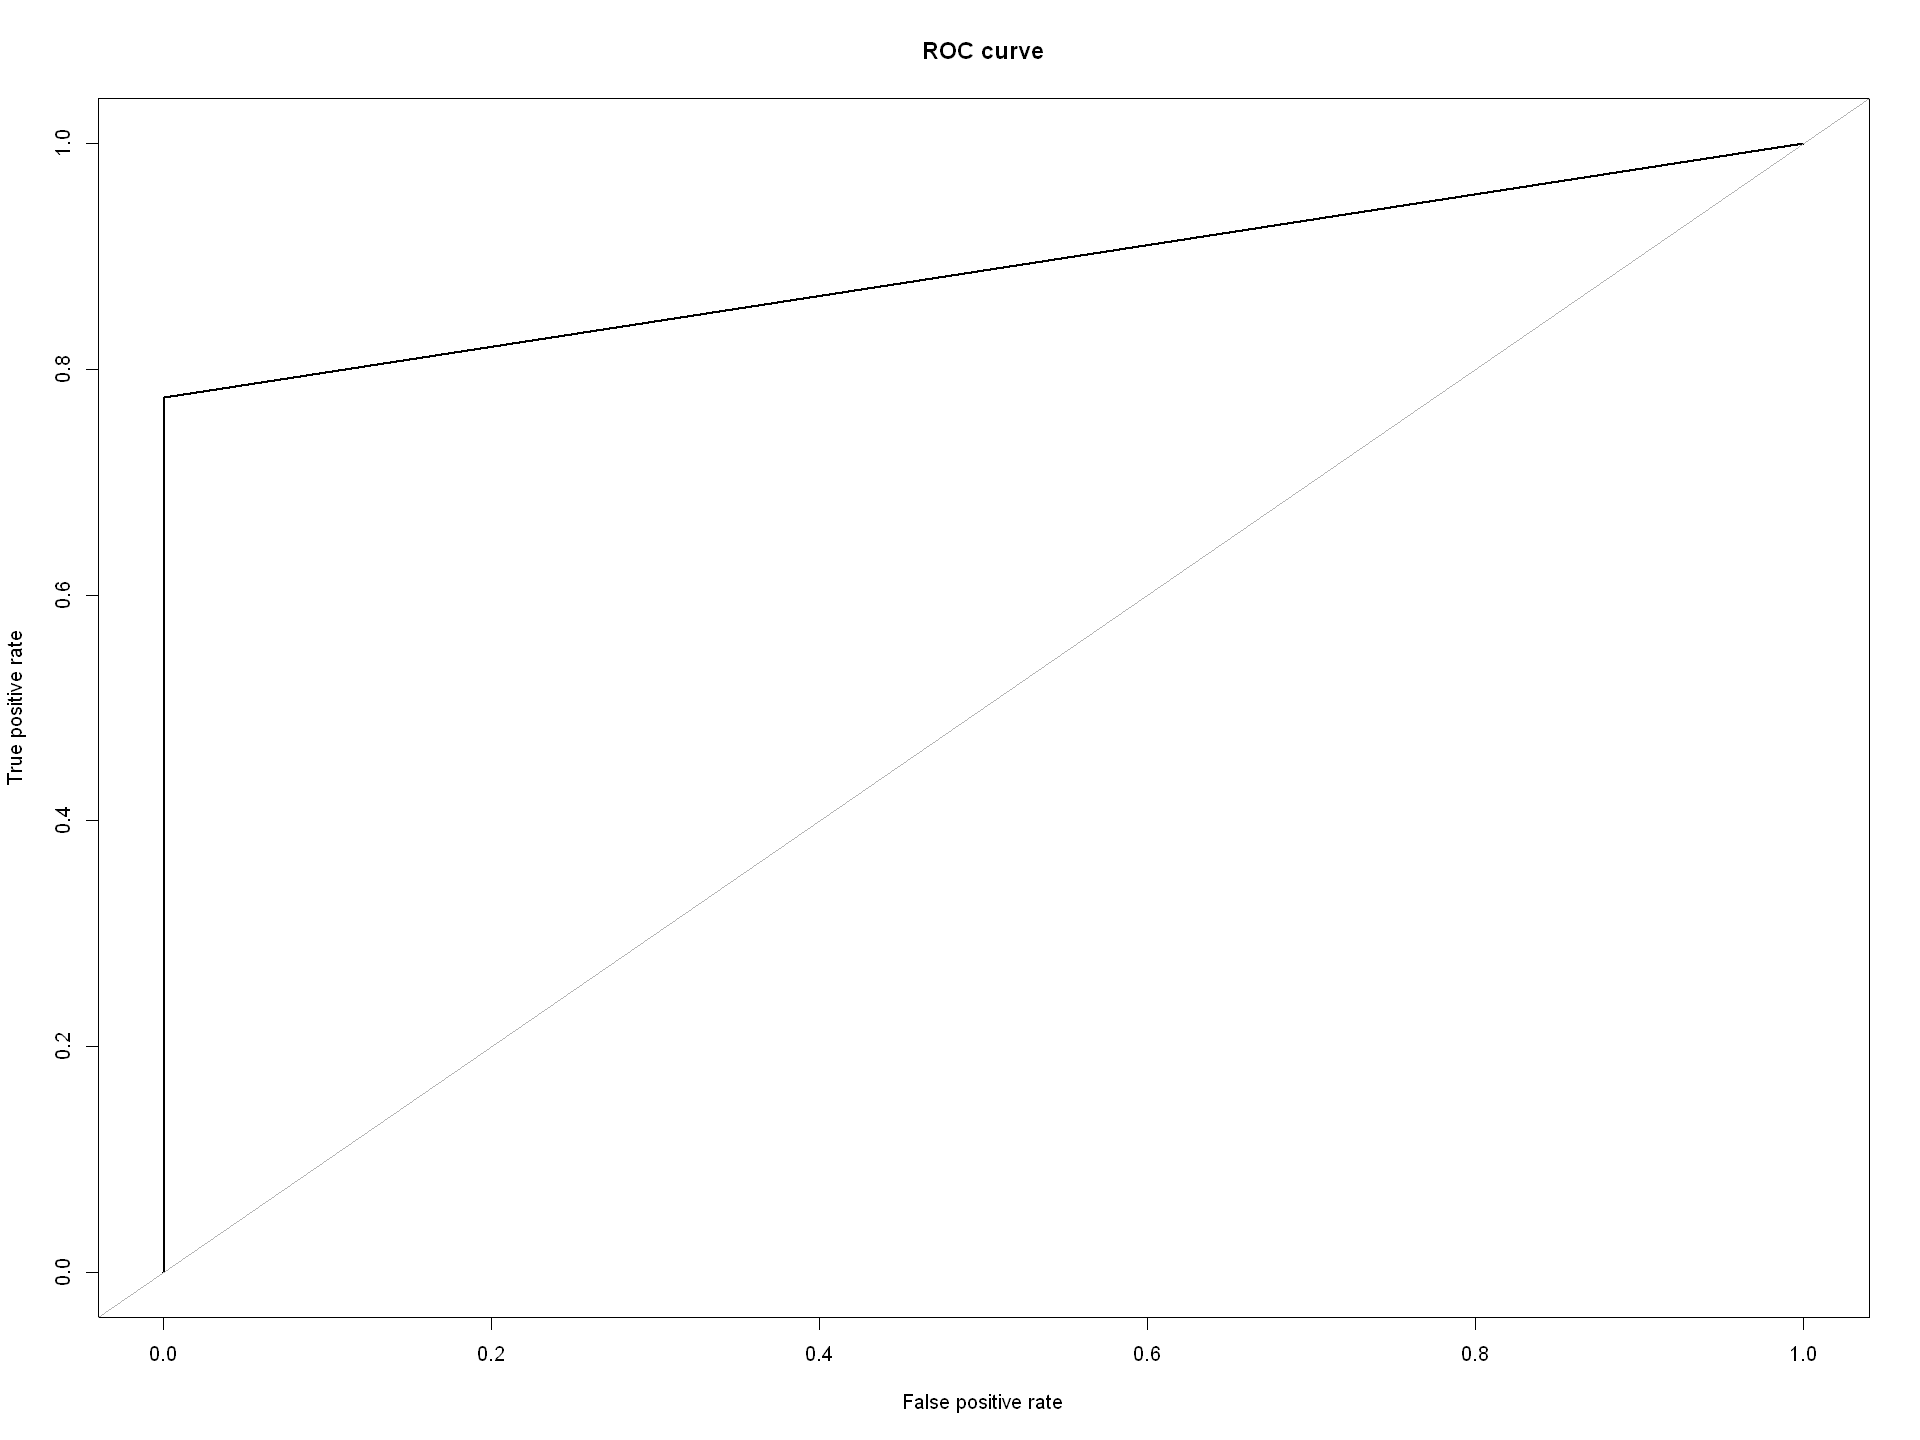

In [23]:
roc.curve(test_df$Class, predict_rf, plotit =TRUE)

## 5. K - NEAREST NEIGHBOURS (KNN) CLASSIFIER

In [24]:
cl <- makeCluster(12)
registerDoParallel(cl)

model_knn <- knn(train = up_train[,-30],
                      test = test_df[,-30],
                      cl = up_train$Class,
                      k = 10)

stopCluster(cl)
registerDoSEQ()

In [25]:
confusionMatrix(data=model_knn,reference=test_df$Class)[[2]]

          Reference
Prediction     0     1
         0 82374    27
         1   196   102

Area under the curve (AUC): 0.894

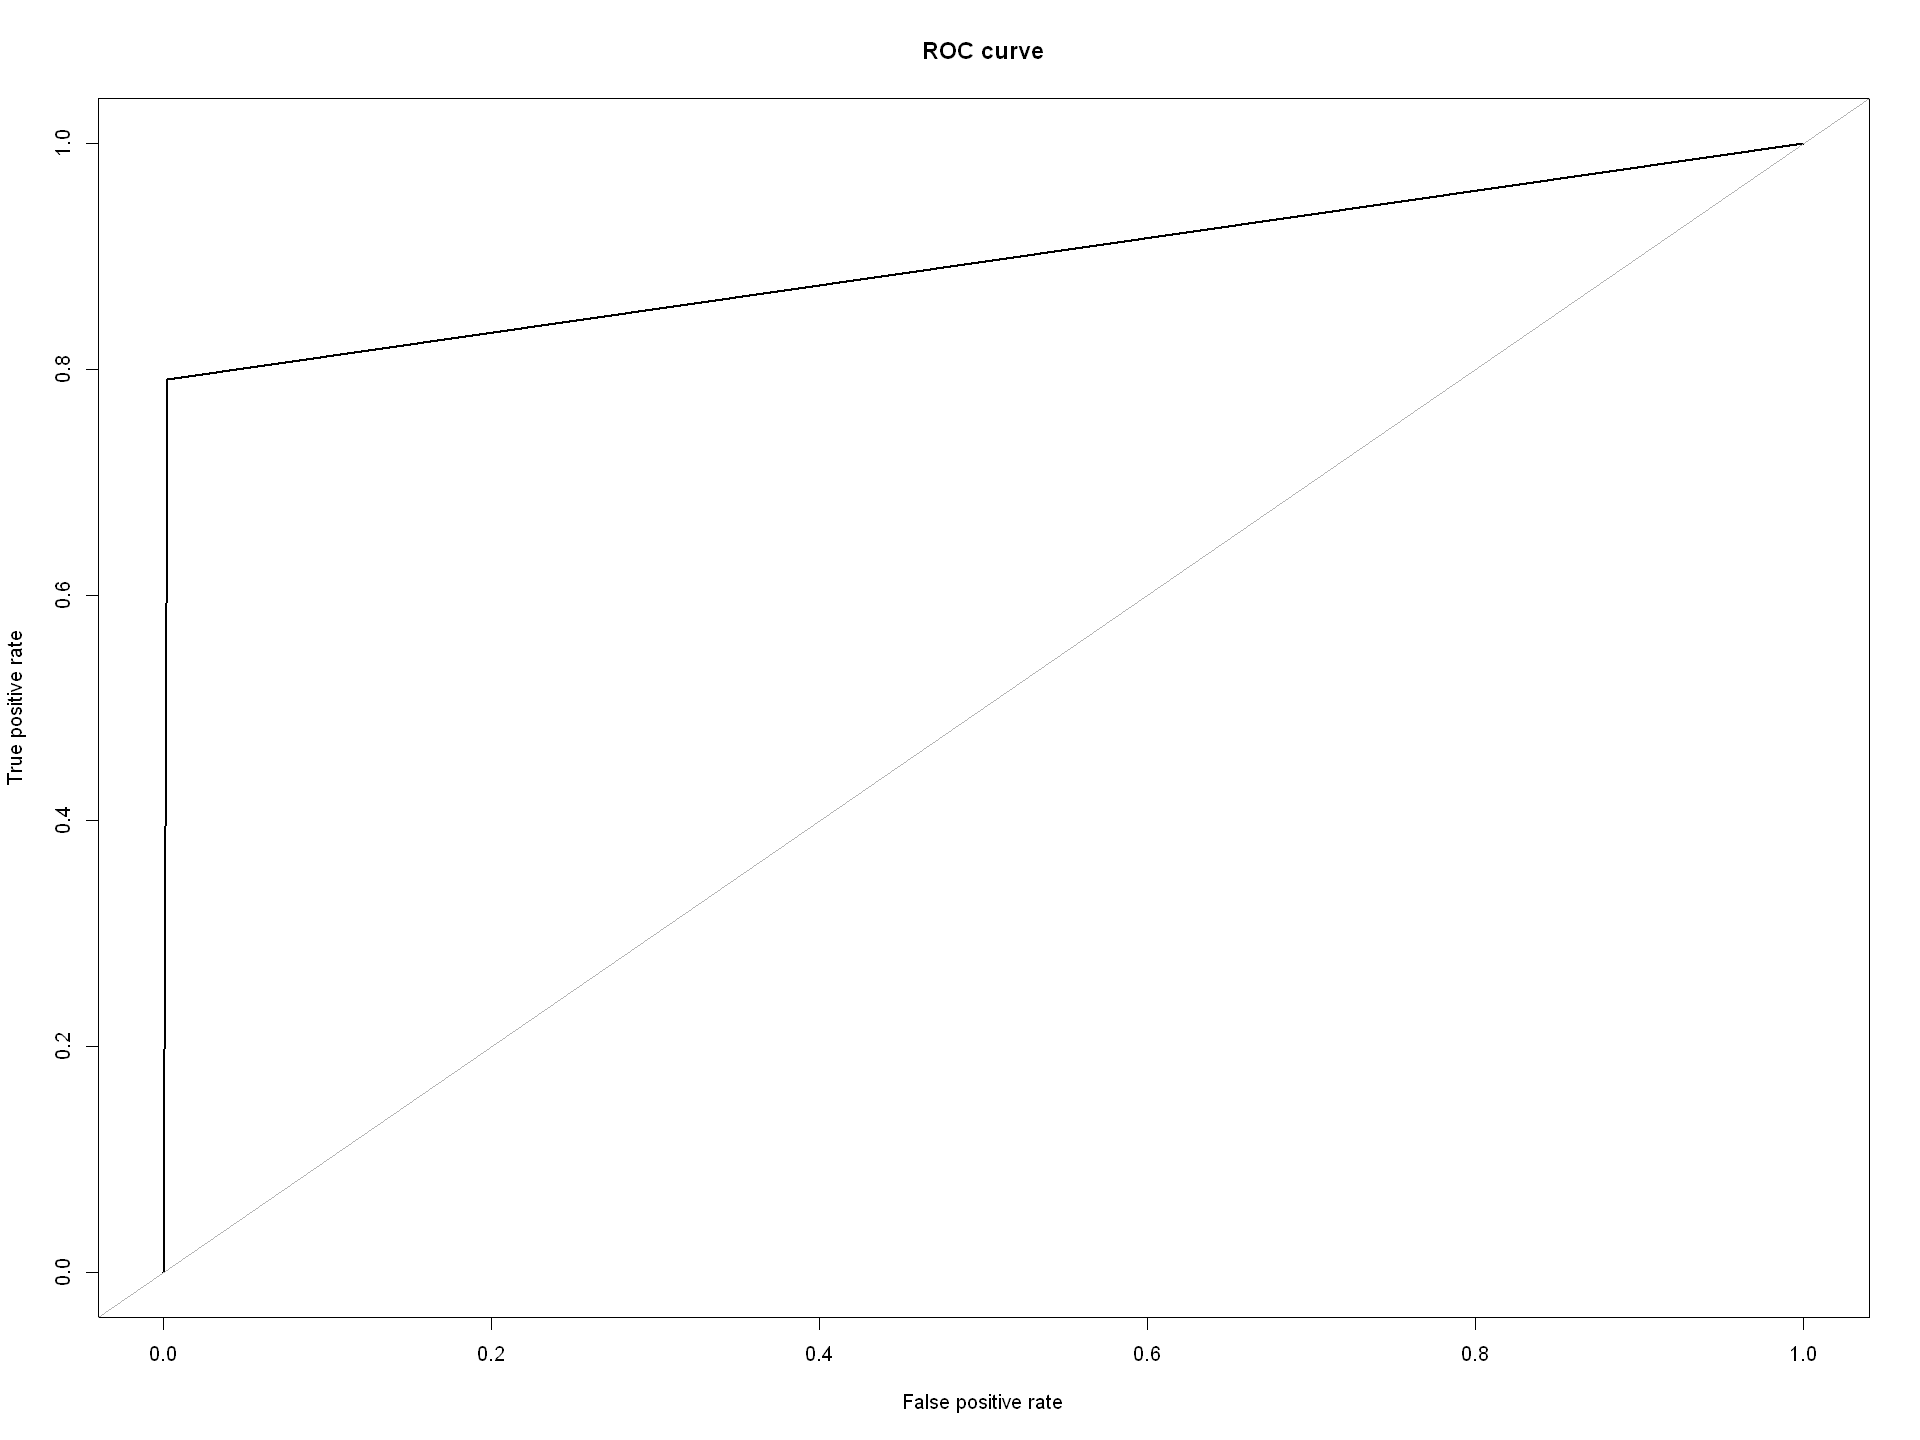

In [26]:
roc.curve(test_df$Class, model_knn, plotit =TRUE)

# III. CONCLUSION 

Based on the result from different models, XGBoost and Logistic Regression seem to be the best suited prediction models for this classification problem since they have the highest AUC scores.